In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
path = "data/"
#path = "data/sample/"
batch_size=64

# Setup Directories

In [6]:
%cd data
%mkdir valid
%cd train

/home/ubuntu/courses/deeplearning1/kaggle/fish/data
/home/ubuntu/courses/deeplearning1/kaggle/fish/data/train


In [7]:
## make the categories directories under valid 
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

In [9]:
## randomly copy 500 over to the valid directory
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [10]:
## make the sample set directories
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [11]:
## make the category directories under sample
g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [12]:
# make the sample set
from shutil import copyfile
g = glob('*/*.jpg')
shuf = np.random.permutation(g)

for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])


/home/ubuntu/courses/deeplearning1/kaggle/fish/data/valid


In [13]:
%mkdir ../results
%mkdir ../sample/results

In [14]:
%cd ../..

/home/ubuntu/courses/deeplearning1/kaggle/fish


# Basic VGG 

Start with VGG approach (with batch norm). VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

In [4]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 13153 images belonging to 2 classes.


In [11]:


raw_test_filenames = [f.split('/')[-1] if "test_stg2" not in f else f for f in test_filenames]


In [13]:
raw_test_filenames[13000]

'test_stg2/image_00884.jpg'

In [14]:
raw_filenames = [f.split('/')[-1] for f in filenames]
#raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [15]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [20]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [16]:
test = get_data(path+'test')

Found 13153 images belonging to 2 classes.


In [21]:
save_array(path+'results/trn.data',trn)
save_array(path+'results/val.data', val)

In [17]:
save_array(path+'results/test.data', test)

In [59]:
trn = load_array(path+'results/trn.data')
val = load_array(path+'results/val.data')

In [ ]:
test = load_array(path+'results/test.data')

In [11]:
gen = image.ImageDataGenerator()

In [18]:
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 101s - loss: 2.7833 - acc: 0.4904 - val_loss: 1.1701 - val_acc: 0.6940
Epoch 2/3
3277/3277 [==============================] - 101s - loss: 1.6297 - acc: 0.6482 - val_loss: 0.8203 - val_acc: 0.7960
Epoch 3/3
3277/3277 [==============================] - 101s - loss: 1.1824 - acc: 0.7147 - val_loss: 0.5736 - val_acc: 0.8520


In [25]:
model.save_weights(path+'results/ft1.h5')

### Precomput convolutional output
pre-comput the output of the last convolution layer of VGG.   (won't fine-tune those layers.

In [19]:
model.load_weights(path+'results/ft1.h5')

In [20]:
conv_layers, fc_layers = split_at(model, Convolution2D)

In [21]:
conv_model = Sequential(conv_layers)

In [28]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [22]:
conv_test_feat = conv_model.predict(test)

In [29]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [23]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [70]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [ ]:
conv_test = load_array(path+'results/conv_test.dat')

### Train model
create the baseline model - simple 3-layer FC net

In [24]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [25]:
p=0.6

In [26]:
bn_model = Sequential (get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3,
            validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 1.1332 - acc: 0.6695 - val_loss: 0.7849 - val_acc: 0.8540
Epoch 2/3
3277/3277 [==============================] - 2s - loss: 0.3002 - acc: 0.9097 - val_loss: 0.3454 - val_acc: 0.9420
Epoch 3/3
3277/3277 [==============================] - 2s - loss: 0.1533 - acc: 0.9561 - val_loss: 0.2844 - val_acc: 0.9560


In [36]:
bn_model.optimizer.lr = 1e-4

In [38]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7,
            validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/7
3277/3277 [==============================] - 2s - loss: 0.0431 - acc: 0.9881 - val_loss: 0.2040 - val_acc: 0.9660
Epoch 2/7
3277/3277 [==============================] - 2s - loss: 0.0376 - acc: 0.9902 - val_loss: 0.2018 - val_acc: 0.9680
Epoch 3/7
3277/3277 [==============================] - 2s - loss: 0.0377 - acc: 0.9915 - val_loss: 0.1930 - val_acc: 0.9740
Epoch 4/7
3277/3277 [==============================] - 2s - loss: 0.0405 - acc: 0.9872 - val_loss: 0.2284 - val_acc: 0.9640
Epoch 5/7
3277/3277 [==============================] - 2s - loss: 0.0399 - acc: 0.9890 - val_loss: 0.1801 - val_acc: 0.9720
Epoch 6/7
3277/3277 [==============================] - 2s - loss: 0.0301 - acc: 0.9908 - val_loss: 0.2217 - val_acc: 0.9680
Epoch 7/7
3277/3277 [==============================] - 2s - loss: 0.0328 - acc: 0.9912 - val_loss: 0.2106 - val_acc: 0.9680


In [41]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [27]:
bn_model.load_weights(path+'models/conv_512_6.h5')

## Submit


In [20]:
def do_clip(arr,mx): return np.clip(arr, (1-mx)/7, mx)

In [21]:
bn_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.21057223349809648, 0.96800000238418582]

In [28]:
preds = bn_model.predict(conv_test_feat, batch_size=batch_size)

In [29]:
preds

array([[  9.9939e-01,   1.9427e-04,   2.7572e-05, ...,   1.0177e-04,   4.3728e-05,   1.9659e-04],
       [  9.7809e-01,   1.5639e-03,   1.2443e-03, ...,   1.7540e-02,   1.6389e-04,   9.1162e-04],
       [  3.8163e-01,   3.1292e-05,   2.9749e-04, ...,   2.9371e-04,   3.0458e-03,   3.8552e-05],
       ..., 
       [  9.8585e-01,   6.9918e-04,   1.7830e-04, ...,   4.3788e-04,   8.3022e-04,   3.8257e-03],
       [  7.9089e-01,   7.3541e-03,   2.5375e-04, ...,   3.9668e-04,   6.6377e-04,   1.8470e-01],
       [  9.4486e-01,   1.5987e-04,   3.0543e-05, ...,   6.3429e-05,   1.0098e-04,   5.7326e-03]], dtype=float32)

In [30]:
preds[1]

array([  9.7809e-01,   1.5639e-03,   1.2443e-03,   7.8865e-05,   4.1014e-04,   1.7540e-02,
         1.6389e-04,   9.1162e-04], dtype=float32)

In [52]:
##preds = preds[1]

In [70]:
##preds = conv_model.predict(test, batch_size=32)

In [31]:
subm = do_clip(preds, 0.82)

In [32]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [33]:
subm_name = path+'results/subm_bb.gz'

In [34]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.394231,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538
1,img_06893.jpg,0.394231,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538
2,img_02082.jpg,0.183814,0.086698,0.086698,0.086698,0.295997,0.086698,0.086698,0.086698
3,img_06261.jpg,0.394231,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538
4,img_03628.jpg,0.394231,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538,0.086538


In [35]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [36]:
FileLink(subm_name)

/home/ubuntu/courses/deeplearning1/kaggle/fish/data/results/subm_bb.gz

## Bounding boxes & multi output

In [49]:
#get the size of the images because photos with the same sizes should be from the same boat
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [51]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 170,
         (1244, 700): 26,
         (1276, 718): 191,
         (1280, 720): 1893,
         (1280, 750): 510,
         (1280, 924): 48,
         (1280, 974): 346,
         (1334, 750): 26,
         (1518, 854): 35,
         (1732, 974): 32})

In [52]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [53]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [54]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [38]:
import ujson as json
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [41]:
bb_json={}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path,c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x:x['height']*x['width'])[-1]

In [42]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [43]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [44]:
## for any images without annotations, create an empty bounding box
empty_bbox = {'height':0., 'width': 0., 'x':0., 'y': 0.}

In [46]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [47]:
## convert the dictionary into an array, convert the coordinates to our resized 224x224 images
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [55]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [61]:
## check our work by drawing one of the annotations
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

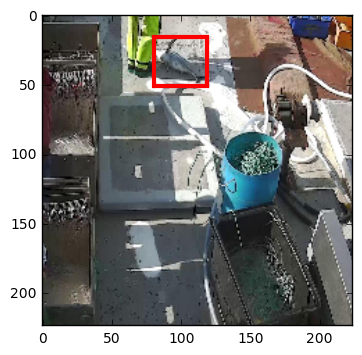

In [64]:
show_bb(3)

## Create & train model
Not allowed to manually annotate test set.
Create a model that predicts the locations of the bounding box on each image.
It will predict
- type of fish
- 4 bounding box coordinates

In [65]:
p = 0.6

In [67]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [68]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [71]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 5.7401 - bb_loss: 4962.9834 - class_loss: 0.7771 - bb_acc: 0.4324 - class_acc: 0.7785 - val_loss: 4.9956 - val_bb_loss: 3715.4239 - val_class_loss: 1.2802 - val_bb_acc: 0.5620 - val_class_acc: 0.8160
Epoch 2/3
3277/3277 [==============================] - 2s - loss: 4.6565 - bb_loss: 4534.3765 - class_loss: 0.1221 - bb_acc: 0.5005 - class_acc: 0.9670 - val_loss: 3.7996 - val_bb_loss: 3553.4177 - val_class_loss: 0.2461 - val_bb_acc: 0.5780 - val_class_acc: 0.9600
Epoch 3/3
3277/3277 [==============================] - 2s - loss: 4.0131 - bb_loss: 3960.7923 - class_loss: 0.0523 - bb_acc: 0.5566 - class_acc: 0.9908 - val_loss: 3.6561 - val_bb_loss: 3440.3265 - val_class_loss: 0.2158 - val_bb_acc: 0.6000 - val_class_acc: 0.9640


In [72]:
model.optimizer.lr=1e-5

In [73]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10,
         validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 2s - loss: 3.3056 - bb_loss: 3280.0128 - class_loss: 0.0255 - bb_acc: 0.5999 - class_acc: 0.9939 - val_loss: 3.1419 - val_bb_loss: 2949.5185 - val_class_loss: 0.1923 - val_bb_acc: 0.6200 - val_class_acc: 0.9700
Epoch 2/10
3277/3277 [==============================] - 2s - loss: 2.5281 - bb_loss: 2506.8660 - class_loss: 0.0212 - bb_acc: 0.6417 - class_acc: 0.9945 - val_loss: 2.3687 - val_bb_loss: 2206.7342 - val_class_loss: 0.1620 - val_bb_acc: 0.6600 - val_class_acc: 0.9660
Epoch 3/10
3277/3277 [==============================] - 2s - loss: 1.7033 - bb_loss: 1683.4698 - class_loss: 0.0198 - bb_acc: 0.6836 - class_acc: 0.9960 - val_loss: 1.6799 - val_bb_loss: 1419.2168 - val_class_loss: 0.2607 - val_bb_acc: 0.7000 - val_class_acc: 0.9640
Epoch 4/10
3277/3277 [==============================] - 2s - loss: 0.9779 - bb_loss: 946.7838 - class_loss: 0.0312 - bb_acc: 0.7293 - class_acc: 0.9948 

In [74]:
## check to see how well the bounding box prediction do.
pred = model.predict(conv_val_feat[0:10])

In [75]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

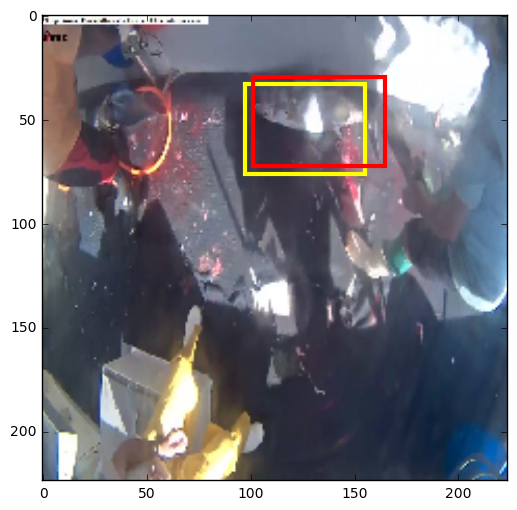

In [76]:
show_bb_pred(6)

In [77]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

500/500 [==============================] - 0s     


[0.46748199832439424,
 229.97927368164062,
 0.23750271155918018,
 0.8000000009536743,
 0.97199999999999998]

In [78]:
model.save_weights(path+'models/bn_anno.h5')

In [ ]:
model.load_weights(path+'models/bn_anno.h5')

## Larger size
Try to use larger size images.   (640x360)


### Set up image size

In [4]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


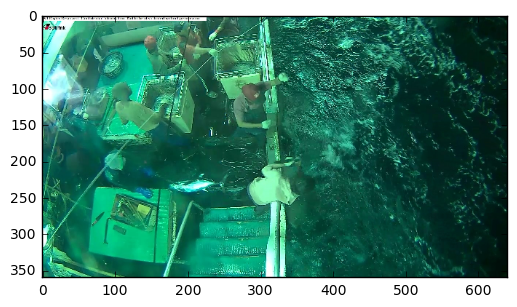

In [5]:
plot(trn[1])

In [ ]:
test = get_data(path+'test', (360,640))

Found 13153 images belonging to 2 classes.


In [6]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)


In [ ]:
save_array(path+'results/test_640.dat', test)

In [ ]:
trn = load_data(path+'results/trn_640.dat')
val = load_data(path+'results/val_640.dat')

In [ ]:
## create VGG model.   Tell that it is not using the normal 224 x 224
## will not use the fully connected layers
## remove the last max pooling layer
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## pre-compute the convolutional part of VGG
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

In [ ]:
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)
save_array(path+'results/conv_val_640.dat', conv_val_feat)


In [ ]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

In [ ]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [ ]:
conv_trn_feat = load_data(path+'results/conv_trn_640.dat')
conv_val_feat = load_data(path+'results/conv_val_640.dat')

In [ ]:
conv_test_feat = load_data(path+'results/conv_test_640.dat')